In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from typing import List, Tuple

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml

import tqdm
tqdm.tqdm.pandas()
#plt.style.use('ggplot')

In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
#mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [145]:
labels_to_plot = [
    'Vanilla GCN',
    'Vanilla GDC',
    'SVD GCN',
    'SVD GCN (rank=50)',
    'SVD GCN (rank=100)',
    'Jaccard GCN',
    'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)',
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.2)', 
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Medoid RPPRGo (T=1.0)',
    'Soft Median RPPRGo (T=5.0)',
    'Soft Median RPPRGo (T=1.0)',
    'Soft Median RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.2)'
]

In [146]:
dataset_map = {
    'cora_ml': r'\textbf{Cora ML}',#'~\citep{Bojchevski2018}}', # '\rotatebox{90}{Cora ML~\citep{Bojchevski2018}}',
    'citeseer': r'\textbf{Citeseer}',#~\citep{McCallum2000}}',
    'pubmed': r'\textbf{PubMed}',#~\citep{Sen2008}}',
    'ogbn-arxiv': r'\textbf{arXiv}',#~\citep{Hu2020}}',
    'ogbn-products': r'\textbf{Products}',#~\citep{Hu2020}}',
    'ogbn-papers100M': r'\textbf{Papers 100M}',#~\citep{Hu2020}}'
}
dataset_order = [dataset_map[k] for k in dataset_map.keys()]

In [147]:
attack_map = {
    'DICE': r'\textbf{DICE}',
    #'GANG': r'\textbf{GANG (ours)}',
    'FGSM': r'\textbf{greedy FGSM}',
    'GreedyRBCD': r'\textbf{GR-BCD (ours)}',
    'PGD': r'\textbf{PGD}',
    'PRBCD': r'\textbf{PR-BCD (ours)}'
}
attack_order = [attack_map[k] for k in attack_map.keys()]

In [148]:
attack_loss_map = {
    'FGSM': 'MCE',
    'GreedyRBCD': 'MCE',
    'PGD': 'tanhMargin',
    'PRBCD': 'tanhMargin'
}
attack_loss_map

{'FGSM': 'MCE',
 'GreedyRBCD': 'MCE',
 'PGD': 'tanhMargin',
 'PRBCD': 'tanhMargin'}

In [149]:
pm = r'\(\pm\)'
bpm = r'\(\boldsymbol{\pm}\)'

In [150]:
def make_max_bold(group):
    for col in list(group.columns):
        if not group[col].isna().all():
            idx = np.where(np.max(group[col].fillna("")) == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\textbf{{{group.loc[group.index[idx], col].iloc[0]}}}'\
                .replace(pm, bpm)
    return group

In [151]:
def make_second_best_underlined(group):
    for col in list(group.columns):
        if not group[col].isna().all() and np.unique(group[col].fillna("")).shape[0] > 1:
            second_max = np.unique(group[col].fillna("").apply(
                lambda v: v.replace(r'\textbf{', '').replace('}', '')
            ))[-2]
            idx = np.where(second_max == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\underline{{{group.loc[group.index[idx], col].iloc[0]}}}'
    return group

In [152]:
def mark_best_and_second_best(group: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              dimension: int = 0) -> pd.DataFrame:
    iterable  

In [153]:
def calc_mean_and_error(values: pd.Series, seeds: pd.Series, with_error=True, decimal_places: int = 3): 
    values, seeds = values.values, seeds.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    values = values[idx]
    
    if with_error:
        return rf'{np.mean(values):.{decimal_places}f} $\pm$ {np.std(values)/len(values):.{decimal_places}f}'
    else:
        return rf'{np.mean(values):.{decimal_places}f}'

In [154]:
from functools import partial

def _mark_best_and_second_best(vector: np.ndarray, 
                               first_mark: str = r'\textbf',
                               second_mark: str = r'\underline',
                               is_higher_better : bool = True) -> np.ndarray:
    vector = vector.astype(object)
    values = np.unique(vector[vector == vector])
    if not len(values):
        return vector
    
    if first_mark:
        if is_higher_better:
            mask = [vector == values[-1]]
        else:
            mask = [vector == values[0]]
        vector[mask] = np.char.add(np.char.add(first_mark + '{', vector[mask]), '}')
    if second_mark:
        if is_higher_better:
            mask = [vector == values[-2]]
        else:
            mask = [vector == values[1]]
        vector[mask] = np.char.add(np.char.add(second_mark + '{', vector[mask]), '}')
    return vector
    

def mark_best_and_second_best(df: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              axis: int = 0,
                              is_higher_better : bool = True) -> pd.DataFrame:
    df[:] = np.apply_along_axis(
        partial(_mark_best_and_second_best, first_mark=first_mark, 
                second_mark=second_mark, is_higher_better=is_higher_better),
        axis=axis,
        arr=df.values
    )
    return df

In [226]:
df_experiments = seml.get_results('neurips21_global_attack_transfer',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])
df_experiments = df_experiments[(df_experiments['config.attack'] != 'GANG')
                                & (df_experiments['batch_id'] >= 13)]
df_experiments.tail()

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.mem,slurm.sbatch_options.gres,config.overwrite,config.db_collection,config.dataset,config.data_dir,config.binary_attr,config.normalize,config.make_undirected,config.make_unweighted,config.normalize_attr,config.seed,config.attack,config.attack_params.loss_type,config.epsilons,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.model_label,config.surrogate_model_storage_type,config.surrogate_model_label,config.device,config.data_device,config.display_steps,result.results,config.attack_params.base_lr,config.attack_params.do_synchronize,config.attack_params.epochs,config.attack_params.fine_tune_epochs,config.attack_params.keep_heuristic,config.attack_params.search_space_size,slurm.sbatch_options.job-name,slurm.sbatch_options.array,slurm.sbatch_options.output,slurm.array_id,slurm.task_id,config.config_hash,config.debug_level,slurm.sbatch_options.partition,config.attack_params.lr_factor
777,1178,30,1,0-08:00,1,4,16G,gpu:1,1178,neurips21_global_attack_transfer,ogbn-arxiv,datasets/,False,NaN,True,NaN,NaN,1,PRBCD,tanhMargin,"[0, 0.01, 0.05, 0.1]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla GCN,0,cpu,NaN,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,True,NaN,NaN,WeightOnly,10000000.0,NaN,NaN,NaN,NaN,NaN,2e4fbea592b66faf76a9fa664f738c25,info,NaN,NaN
778,1179,30,1,0-08:00,1,4,16G,gpu:1,1179,neurips21_global_attack_transfer,ogbn-arxiv,datasets/,False,NaN,True,NaN,NaN,5,PRBCD,tanhMargin,"[0, 0.01, 0.05, 0.1]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla GCN,0,cpu,NaN,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,True,NaN,NaN,WeightOnly,10000000.0,NaN,NaN,NaN,NaN,NaN,e52554a7a946a32c8fe1e87a04c18a79,info,NaN,NaN
779,1180,30,1,0-08:00,1,4,16G,gpu:1,1180,neurips21_global_attack_transfer,ogbn-arxiv,datasets/,False,NaN,True,NaN,NaN,0,DICE,NaN,"[0, 0.01, 0.05, 0.1]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla GCN,0,cpu,NaN,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e8742a6a4295607a285e62d01850f88a,info,NaN,NaN
780,1181,30,1,0-08:00,1,4,16G,gpu:1,1181,neurips21_global_attack_transfer,ogbn-arxiv,datasets/,False,NaN,True,NaN,NaN,1,DICE,NaN,"[0, 0.01, 0.05, 0.1]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla GCN,0,cpu,NaN,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b9ce1fe1225695236ee4cdfbcd4f5c98,info,NaN,NaN
781,1182,30,1,0-08:00,1,4,16G,gpu:1,1182,neurips21_global_attack_transfer,ogbn-arxiv,datasets/,False,NaN,True,NaN,NaN,5,DICE,NaN,"[0, 0.01, 0.05, 0.1]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla GCN,0,cpu,NaN,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55b916db8f32071e25a445bf3f22f882,info,NaN,NaN


In [227]:
# df_experiments.to_csv('notebooks/kdd21_rgnn_at_scale_attack_evasion_transfer.csv')

In [228]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.time', 'slurm.sbatch_options.nodes',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.gres', 'config.overwrite', 'config.db_collection',
       'config.dataset', 'config.data_dir', 'config.binary_attr',
       'config.normalize', 'config.make_undirected', 'config.make_unweighted',
       'config.normalize_attr', 'config.seed', 'config.attack',
       'config.attack_params.loss_type', 'config.epsilons',
       'config.artifact_dir', 'config.pert_adj_storage_type',
       'config.pert_attr_storage_type', 'config.model_storage_type',
       'config.model_label', 'config.surrogate_model_storage_type',
       'config.surrogate_model_label', 'config.device', 'config.data_device',
       'config.display_steps', 'result.results',
       'config.attack_params.base_lr', 'config.attack_params.do_synchronize',
       'config.attack_params.epochs', 'config.attack_

In [229]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = experiment['config.dataset']
    df_result['attack'] = experiment['config.attack']
    df_result['seed'] = experiment['config.seed']
    df_result['batch_id'] = experiment['batch_id']
    df_result['novel_loss'] = (
        experiment['config.attack'] not in attack_loss_map
        or experiment['config.attack_params.loss_type'] == attack_loss_map[experiment['config.attack']]
    )
    df_result['lr'] = experiment['config.attack_params.base_lr']
    
df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss,lr
502,Soft Medoid GDC (T=0.2),0.01,0.768128,pubmed,DICE,5,13,True,NaN
497,Soft Medoid GDC (T=1.0),0.01,0.798643,pubmed,DICE,5,13,True,NaN
496,Vanilla GDC,0.01,0.786753,pubmed,DICE,5,13,True,NaN
495,Vanilla GCN,0.01,0.788896,pubmed,DICE,5,13,True,NaN
506,Soft Median GDC (T=1.0),0.01,0.796295,pubmed,DICE,5,13,True,NaN
...,...,...,...,...,...,...,...,...,...
20959,Vanilla GDC,0.00,0.703948,ogbn-arxiv,PRBCD,0,30,True,NaN
20960,Soft Median GDC (T=0.2),0.00,0.663622,ogbn-arxiv,PRBCD,0,30,True,NaN
20961,Soft Median GDC (T=0.5),0.00,0.669115,ogbn-arxiv,PRBCD,0,30,True,NaN
20953,Vanilla PPRGo,0.10,0.542950,ogbn-arxiv,GreedyRBCD,5,30,True,NaN


In [230]:
df_results.attack.unique()

array(['DICE', 'PRBCD', 'GreedyRBCD', 'PGD', 'FGSM'], dtype=object)

In [231]:
df_results.dataset.unique()

array(['pubmed', 'ogbn-products', 'citeseer', 'cora_ml', 'ogbn-arxiv'],
      dtype=object)

In [232]:
df_results[df_results.dataset == 'cora_ml'].label.unique()

array(['Vanilla Dense GCN', 'Vanilla GDC', 'Soft Medoid GDC (T=0.5)',
       'Soft Median GDC (T=1.0)', 'Soft Median GDC (T=0.5)',
       'Soft Median GDC (T=0.2)', 'SVD GCN (rank=50)', 'Vanilla GCN',
       'SVD GCN (rank=100)', 'RGCN', 'Vanilla PPRGo',
       'Soft Medoid RPPRGo (T=1.0)', 'Soft Medoid RPPRGo (T=0.5)',
       'Soft Medoid RPPRGo (T=0.2)', 'Soft Median RPPRGo (T=1.0)',
       'Soft Median RPPRGo (T=0.5)', 'Jaccard GCN',
       'Soft Median RPPRGo (T=0.2)'], dtype=object)

In [233]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\textbf{Attack}'
epsilons_c = r'Frac. edges \(\boldsymbol{\epsilon}\)'
accuracy_c = r'\textbf{Acc.}'

epsilons = [0.01, 0.05, 0.1] #[0.01, 0.05, 0.1, 0.25]
best_attack_mark = r'\textbf'
best_defense_mark = r'\underline'

In [234]:
def transform_label(label: str):
    return (
        label.replace('\n', ' ')
        .replace('RPPRGo', 'PPRGo')
        #.replace(' (T=0.5)','')
        #.replace(' (T=0.2)','')
        #.replace(' (T=5.0)','')
    )

In [235]:
df_results['label'].apply(transform_label).unique()

array(['Soft Medoid GDC (T=0.2)', 'Soft Medoid GDC (T=1.0)',
       'Vanilla GDC', 'Vanilla GCN', 'Soft Median GDC (T=1.0)',
       'Soft Medoid GDC (T=0.5)', 'Soft Median GDC (T=0.2)',
       'Soft Median GDC (T=0.5)', 'Soft Median GDC (T=10.0)',
       'Soft Median GDC (T=5.0)', 'Soft Median PPRGo (T=0.2)',
       'Vanilla GCN (surrogate)', 'Vanilla Dense GCN',
       'SVD GCN (rank=100)', 'SVD GCN (rank=50)', 'Jaccard GCN', 'RGCN',
       'Vanilla PPRGo', 'Soft Medoid PPRGo (T=1.0)',
       'Soft Medoid PPRGo (T=0.2)', 'Soft Median PPRGo (T=0.5)',
       'Soft Medoid PPRGo (T=0.5)', 'Soft Median PPRGo (T=1.0)',
       'Soft Medoid GDC (T=5.0)', 'Soft Median PPRGo (T=5.0)'],
      dtype=object)

In [236]:
df = []

for (dataset, attack, label, epsilon), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon}-{label} collected runs for seed {df_group.seed.tolist()}')
    if label == 'Soft Median GDC (T=0.2)' and dataset == 'ogbn-products':
        continue
    if label == 'Soft Median GDC (T=5.0)' and dataset == 'ogbn-arxiv':
        continue

    values, seeds = df_group.accuracy.values, df_group.seed.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    accuracy = values[idx].mean()
    
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy
    })
    
df = pd.DataFrame(df)

df = df[
    ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
    #& ~((df[architecture_c] == transform_label('Soft Medoid GDC (T=0.5)')) & (df[dataset_c] == dataset_map['pubmed']))
]

df

For ogbn-arxiv-GreedyRBCD-0.25-Soft Median GDC (T=0.2) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Soft Median GDC (T=5.0) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Soft Median RPPRGo (T=0.2) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Soft Median RPPRGo (T=0.5) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Soft Median RPPRGo (T=1.0) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Soft Medoid GDC (T=0.5) collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Vanilla GCN collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Vanilla GDC collected runs for seed [5, 0]
For ogbn-arxiv-GreedyRBCD-0.25-Vanilla PPRGo collected runs for seed [5, 0]
For ogbn-products-DICE-0.0-Soft Median RPPRGo (T=0.2) collected runs for seed [1]
For ogbn-products-DICE-0.01-Soft Median RPPRGo (T=0.2) collected runs for seed [1]
For ogbn-products-DICE-0.05-Soft Median RPPRGo (T=0.2) collected runs for seed [1]
For

,,\textbf{Architecture},\textbf{Attack},Frac. edges \(\boldsymbol{\epsilon}\),accuracy
0,\textbf{Citeseer},Jaccard GCN,\textbf{DICE},0.00,0.721034
1,\textbf{Citeseer},Jaccard GCN,\textbf{DICE},0.01,0.719608
2,\textbf{Citeseer},Jaccard GCN,\textbf{DICE},0.05,0.715686
3,\textbf{Citeseer},Jaccard GCN,\textbf{DICE},0.10,0.708021
4,\textbf{Citeseer},Jaccard GCN,\textbf{DICE},0.25,0.685918
...,...,...,...,...,...
1015,\textbf{PubMed},Vanilla GDC,\textbf{PR-BCD (ours)},0.10,0.645065
1016,\textbf{PubMed},Vanilla PPRGo,\textbf{PR-BCD (ours)},0.00,0.780017
1017,\textbf{PubMed},Vanilla PPRGo,\textbf{PR-BCD (ours)},0.01,0.750523
1018,\textbf{PubMed},Vanilla PPRGo,\textbf{PR-BCD (ours)},0.05,0.717423


In [237]:
df_accuracy = df[(df[epsilons_c] == 0) & (df[attack_c] == attack_map['PRBCD'])]
df_accuracy = df_accuracy.drop(columns=[attack_c, epsilons_c])
df_accuracy[dataset_c] = df_accuracy[dataset_c].apply(lambda dataset: rf'\rotatebox{{90}}{{{dataset}}}')
df_accuracy = df_accuracy.set_index([dataset_c, architecture_c])
df_accuracy.columns = pd.MultiIndex.from_product([[accuracy_c], [' ']])

df_accuracy

\textbf{Acc.}
                                                                         
                                  \textbf{Architecture}                  
\rotatebox{90}{\textbf{Citeseer}} Jaccard GCN                    0.721034
                                  RGCN                           0.686453
                                  SVD GCN (rank=100)             0.634403
                                  SVD GCN (rank=50)              0.645633
                                  Soft Median GDC (T=0.2)        0.708200
                                  Soft Median PPRGo (T=0.2)      0.712121
                                  Soft Median PPRGo (T=0.5)      0.715508
                                  Soft Median PPRGo (T=1.0)      0.715330
                                  Soft Medoid GDC (T=0.5)        0.708200
                                  Soft Medoid PPRGo (T=0.2)      0.704813
                                  Soft Medoid PPRGo (T=0.5)      0.706239
                                  Soft Medoid PPRGo (T=1.0)      0.720856
                                  Vanilla GCN                    0.715865
                                  Vanilla GDC                    0.707487
                                  Vanilla PPRGo                  0.726025
\rotatebox{90}{\textbf{Cora ML}}  Jaccard GCN                    0.817523
                                  RGCN                           0.818972
                                  SVD GCN (rank=100)             0.796574
                                  SVD GCN (rank=50)              0.780501
                                  Soft Median GDC (T=0.2)        0.823584
                                  Soft Median PPRGo (T=0.2)      0.808827
                                  Soft Median PPRGo (T=0.5)      0.821344
                                  Soft Median PPRGo (T=1.0)      0.803821
                                  Soft Medoid GDC (T=0.5)        0.819499
                                  Soft Medoid PPRGo (T=0.2)      0.800922
                                  Soft Medoid PPRGo (T=0.5)      0.822925
                                  Soft Medoid PPRGo (T=1.0)      0.823847
                                  Vanilla GCN                    0.827404
                                  Vanilla GDC                    0.841897
                                  Vanilla PPRGo                  0.826219
\rotatebox{90}{\textbf{arXiv}}    Soft Median GDC (T=0.2)        0.663080
                                  Soft Median PPRGo (T=0.2)      0.593043
                                  Soft Median PPRGo (T=0.5)      0.595334
                                  Soft Median PPRGo (T=1.0)      0.591802
                                  Soft Medoid GDC (T=0.5)        0.567084
                                  Vanilla GCN                    0.706500
                                  Vanilla GDC                    0.700704
                                  Vanilla PPRGo                  0.672407
\rotatebox{90}{\textbf{Products}} Soft Median GDC (T=5.0)        0.656004
                                  Soft Median PPRGo (T=0.2)      0.617578
                                  Vanilla GCN                    0.751484
                                  Vanilla GDC                    0.736011
\rotatebox{90}{\textbf{PubMed}}   Soft Median GDC (T=0.2)        0.768808
                                  Soft Median PPRGo (T=0.2)      0.730027
                                  Soft Median PPRGo (T=0.5)      0.710041
                                  Soft Median PPRGo (T=1.0)      0.715807
                                  Soft Median PPRGo (T=5.0)      0.776088
                                  Soft Medoid GDC (T=0.5)        0.774132
                                  Vanilla GCN                    0.781055
                                  Vanilla GDC                    0.781225
                                  Vanilla PPRGo                  0.780017

In [238]:
df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    list(dict.fromkeys([transform_label(l) for l in labels_to_plot]).keys()),
    inplace=True
)
df[dataset_c] = df[dataset_c].apply(lambda cat: rf'\rotatebox{{90}}{{{cat}}}').astype("category")
df[dataset_c].cat.set_categories(
    [rf'\rotatebox{{90}}{{{cat}}}' for cat in dataset_order],
    inplace=True
)

#df = df.sort_values([dataset_c, architecture_c])

df = df[df[epsilons_c].isin(epsilons)].copy()

df

,,\textbf{Architecture},\textbf{Attack},Frac. edges \(\boldsymbol{\epsilon}\),accuracy
1,\rotatebox{90}{\textbf{Citeseer}},Jaccard GCN,\textbf{DICE},0.01,0.719608
2,\rotatebox{90}{\textbf{Citeseer}},Jaccard GCN,\textbf{DICE},0.05,0.715686
3,\rotatebox{90}{\textbf{Citeseer}},Jaccard GCN,\textbf{DICE},0.10,0.708021
6,\rotatebox{90}{\textbf{Citeseer}},RGCN,\textbf{DICE},0.01,0.684314
7,\rotatebox{90}{\textbf{Citeseer}},RGCN,\textbf{DICE},0.05,0.675936
...,...,...,...,...,...
1014,\rotatebox{90}{\textbf{PubMed}},Vanilla GDC,\textbf{PR-BCD (ours)},0.05,0.695702
1015,\rotatebox{90}{\textbf{PubMed}},Vanilla GDC,\textbf{PR-BCD (ours)},0.10,0.645065
1017,\rotatebox{90}{\textbf{PubMed}},Vanilla PPRGo,\textbf{PR-BCD (ours)},0.01,0.750523
1018,\rotatebox{90}{\textbf{PubMed}},Vanilla PPRGo,\textbf{PR-BCD (ours)},0.05,0.717423


In [239]:
df[df[architecture_c] == 'Vanilla PPRGo']

,,\textbf{Architecture},\textbf{Attack},Frac. edges \(\boldsymbol{\epsilon}\),accuracy
71,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{DICE},0.01,0.724064
72,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{DICE},0.05,0.718717
73,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{DICE},0.10,0.708021
146,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{greedy FGSM},0.01,0.714617
147,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{greedy FGSM},0.05,0.676649
148,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{greedy FGSM},0.10,0.644207
221,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{GR-BCD (ours)},0.01,0.713012
222,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{GR-BCD (ours)},0.05,0.681105
223,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{GR-BCD (ours)},0.10,0.662032
296,\rotatebox{90}{\textbf{Citeseer}},Vanilla PPRGo,\textbf{PGD},0.01,0.711765


In [240]:
df_accuracy_baseline = df_accuracy.reset_index()
df_accuracy_baseline = df_accuracy_baseline[df_accuracy_baseline[architecture_c] == 'Vanilla GCN']
df_accuracy_baseline = df_accuracy_baseline.set_index(dataset_c)
df_accuracy_baseline = df_accuracy_baseline.iloc[:, df_accuracy_baseline.columns.get_level_values(0)==accuracy_c]
df_accuracy_baseline

,\textbf{Acc.}
,
,
\rotatebox{90}{\textbf{Citeseer}},0.715865
\rotatebox{90}{\textbf{Cora ML}},0.827404
\rotatebox{90}{\textbf{arXiv}},0.706500
\rotatebox{90}{\textbf{Products}},0.751484
\rotatebox{90}{\textbf{PubMed}},0.781055


In [243]:
df_piv = pd.pivot_table(
    df, 
    index=[dataset_c, architecture_c], 
    columns=[attack_c, epsilons_c], #['type', attack_c, ' '], 
    values='accuracy'#,
    #aggfunc=lambda x: ' '.join(x)
)

df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

df_piv = pd.merge(df_piv, df_accuracy, on=['   ', architecture_c], how='left')

#df_piv = df_piv.apply(lambda row: row[-1] - row[:-1], axis=1).round(3)
df_piv = df_piv.round(3)

print(df_piv.to_markdown().replace(' ', ''))

best_defenses = []
for i in np.array(df_piv.index.get_level_values(0).unique()):
    df_slice = df_piv.loc[(i, slice(None))]
    best_defenses.append([df_slice[col].astype(float).argmax() for col in df_slice])

df_piv = df_piv.applymap(lambda val: str(val) if val == val else val)
for epsilon in epsilons:
    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
        partial(mark_best_and_second_best, first_mark=best_attack_mark, second_mark='', axis=1, is_higher_better=False)
    )

for i, bests in zip(np.array(df_piv.index.get_level_values(0).unique()), best_defenses):
    df_slice = df_piv.loc[(i, slice(None))]
    for col, best in zip(df_slice, bests):
        if best == -1:
            continue
        df_slice.loc[df_slice.index[best], col] = rf'{best_defense_mark}{{{df_slice.loc[df_slice.index[best], col]}}}'
    

#df_piv = pd.merge(df_piv, df_accuracy.round(2), on=['   ', architecture_c], how='left')
df_piv = df_piv.fillna('-')
df_piv

||('\\textbf{DICE}',0.01)|('\\textbf{DICE}',0.05)|('\\textbf{DICE}',0.1)|('\\textbf{greedyFGSM}',0.01)|('\\textbf{greedyFGSM}',0.05)|('\\textbf{greedyFGSM}',0.1)|('\\textbf{GR-BCD(ours)}',0.01)|('\\textbf{GR-BCD(ours)}',0.05)|('\\textbf{GR-BCD(ours)}',0.1)|('\\textbf{PGD}',0.01)|('\\textbf{PGD}',0.05)|('\\textbf{PGD}',0.1)|('\\textbf{PR-BCD(ours)}',0.01)|('\\textbf{PR-BCD(ours)}',0.05)|('\\textbf{PR-BCD(ours)}',0.1)|('\\textbf{Acc.}','')|
|:---------------------------------------------------------------------|---------------------------:|---------------------------:|--------------------------:|----------------------------------:|----------------------------------:|---------------------------------:|------------------------------------:|------------------------------------:|-----------------------------------:|--------------------------:|--------------------------:|-------------------------:|------------------------------------:|------------------------------------:|--------------------

<ipython-input-154-6cca4f51faed>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vector[mask] = np.char.add(np.char.add(first_mark + '{', vector[mask]), '}')


\textbf{Attack}                                                  \textbf{DICE}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                     0.01   
                                  \textbf{Architecture}                          
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                            0.825   
                                  Vanilla GDC                \underline{0.839}   
                                  SVD GCN (rank=50)                      0.778   
                                  SVD GCN (rank=100)            \textbf{0.567}   
                                  Jaccard GCN                            0.815   
                                  RGCN                                   0.816   
                                  Soft Medoid GDC (T=0.5)                0.818   
                                  Soft Median GDC (T=0.2)                0.822   
                                  Vanilla PPRGo                          0.824   
                                  Soft Medoid PPRGo (T=0.2)              0.798   
                                  Soft Medoid PPRGo (T=0.5)              0.821   
                                  Soft Medoid PPRGo (T=1.0)              0.822   
                                  Soft Median PPRGo (T=1.0)              0.803   
                                  Soft Median PPRGo (T=0.5)              0.819   
                                  Soft Median PPRGo (T=0.2)              0.806   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                            0.714   
                                  Vanilla GDC                            0.704   
                                  SVD GCN (rank=50)                      0.643   
                                  SVD GCN (rank=100)                     0.634   
                                  Jaccard GCN                             0.72   
                                  RGCN                                   0.684   
                                  Soft Medoid GDC (T=0.5)                0.707   
                                  Soft Median GDC (T=0.2)                0.709   
                                  Vanilla PPRGo              \underline{0.724}   
                                  Soft Medoid PPRGo (T=0.2)              0.703   
                                  Soft Medoid PPRGo (T=0.5)              0.705   
                                  Soft Medoid PPRGo (T=1.0)              0.721   
                                  Soft Median PPRGo (T=1.0)              0.713   
                                  Soft Median PPRGo (T=0.5)              0.714   
                                  Soft Median PPRGo (T=0.2)              0.709   
\rotatebox{90}{\textbf{PubMed}}   Vanilla GCN                            0.778   
                                  Vanilla GDC                            0.778   
                                  Soft Medoid GDC (T=0.5)                0.772   
                                  Soft Median GDC (T=0.2)                0.768   
                                  Vanilla PPRGo              \underline{0.779}   
                                  Soft Median PPRGo (T=1.0)               0.77   
                                  Soft Median PPRGo (T=0.5)     \textbf{0.705}   
                                  Soft Median PPRGo (T=0.2)               0.73   
                                  Soft Median PPRGo (T=5.0)              0.778   
\rotatebox{90}{\textbf{arXiv}}    Vanilla GCN                \underline{0.703}   
                                  Vanilla GDC                            0.694   
                                  Soft Medoid GDC (T=0.5)                0.564   
                                  Soft Median GDC (T=0.2)                0.657   
                                  Vanilla PPRGo                          0.671   
                                  Soft Median PPRGo (T=1.0)              0.594   
                                  Soft Median PPRGo (T=0.5)     

In [45]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        #float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global}
\begin{tabular}{llccccccccccccccccccccccccc}
\toprule
                                  & \textbf{Attack} & \multicolumn{3}{l

# Plot Results (joint)

In [46]:
epsilons_c = r'Frac. edges $\epsilon$'

In [47]:
labels_non_batched = [
    'Vanilla GCN',
    'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)'
]

lables_batched = [
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.5)'
]

attacks = ['FGSM', 'GreedyRBCD', 'PGD', 'PRBCD']

In [48]:
df_results[
    ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
]

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss,lr
0,Vanilla GCN,0.00,0.778640,pubmed,GreedyRBCD,0,13,True,NaN
361,Vanilla GDC,0.00,0.783487,pubmed,DICE,0,13,True,NaN
360,Vanilla GCN,0.00,0.778640,pubmed,DICE,0,13,True,NaN
352,Soft Medoid GDC (T=0.2),0.10,0.737052,pubmed,PRBCD,5,13,True,NaN
351,Soft Medoid GDC (T=0.5),0.10,0.731081,pubmed,PRBCD,5,13,True,NaN
...,...,...,...,...,...,...,...,...,...
9250,Vanilla GDC,0.01,0.638522,ogbn-products,GreedyRBCD,0,21,True,NaN
9245,Vanilla GCN (surrogate),0.00,0.721687,ogbn-products,GreedyRBCD,0,21,True,NaN
9244,Vanilla GCN,0.00,0.752346,ogbn-products,GreedyRBCD,0,21,True,NaN
9246,Vanilla GDC,0.00,0.733569,ogbn-products,GreedyRBCD,0,21,True,NaN


citeseer FGSM
citeseer GreedyRBCD


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD
citeseer PRBCD
cora_ml FGSM


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases

cora_ml GreedyRBCD
cora_ml PGD
cora_ml PRBCD


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases

ogbn-arxiv GreedyRBCD
ogbn-arxiv PRBCD
ogbn-products GreedyRBCD
pubmed GreedyRBCD


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases

pubmed PRBCD


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


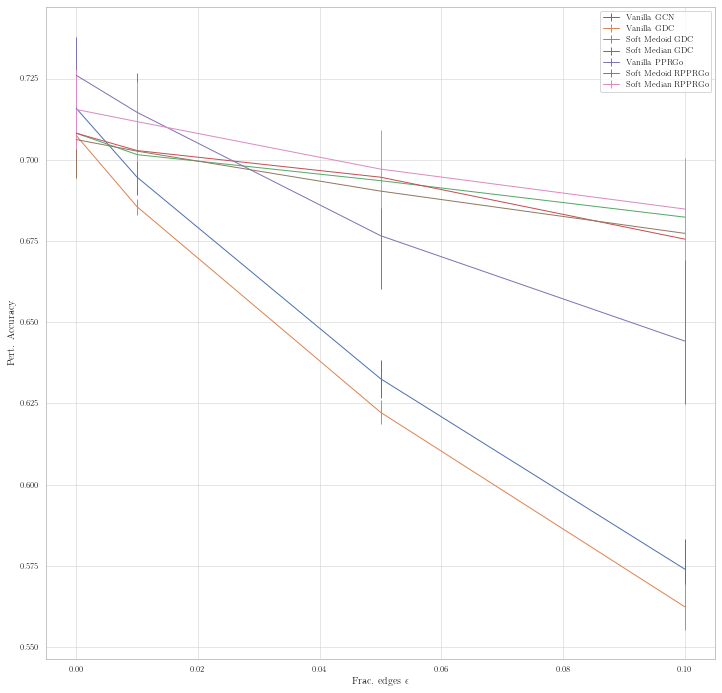

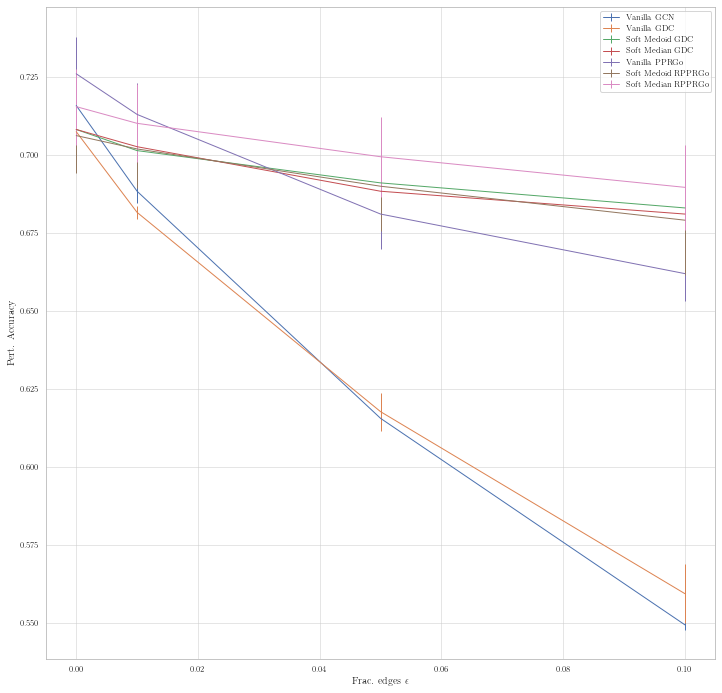

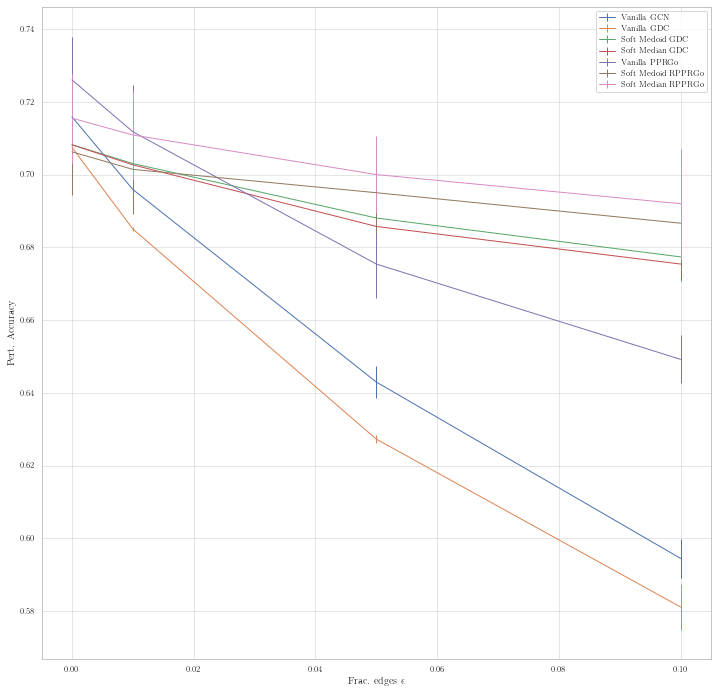

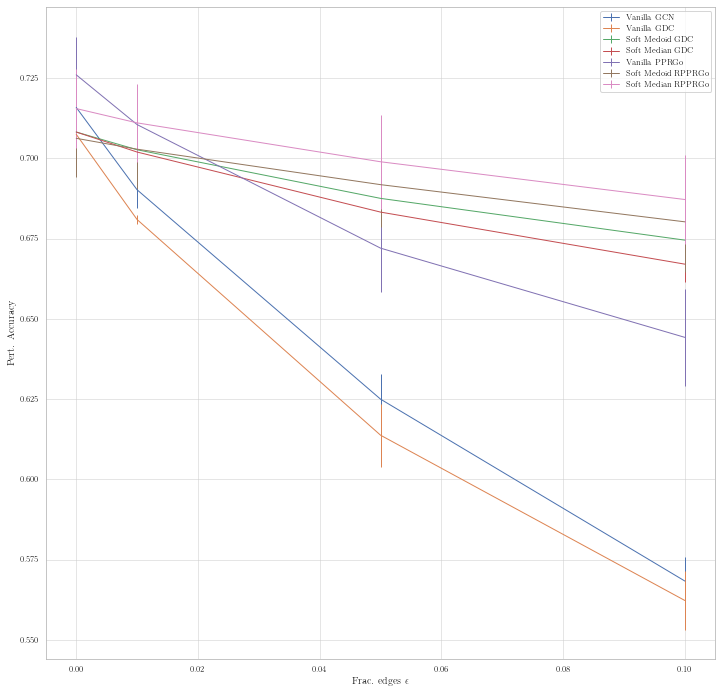

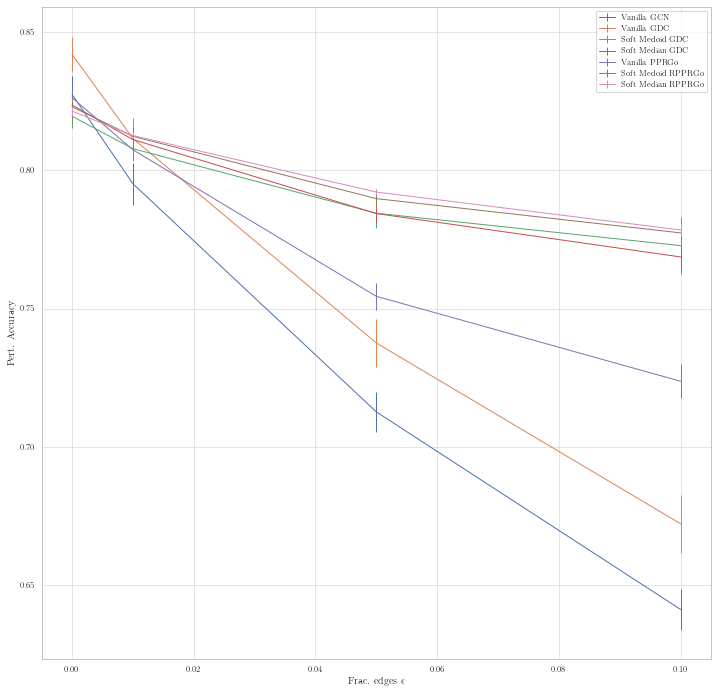

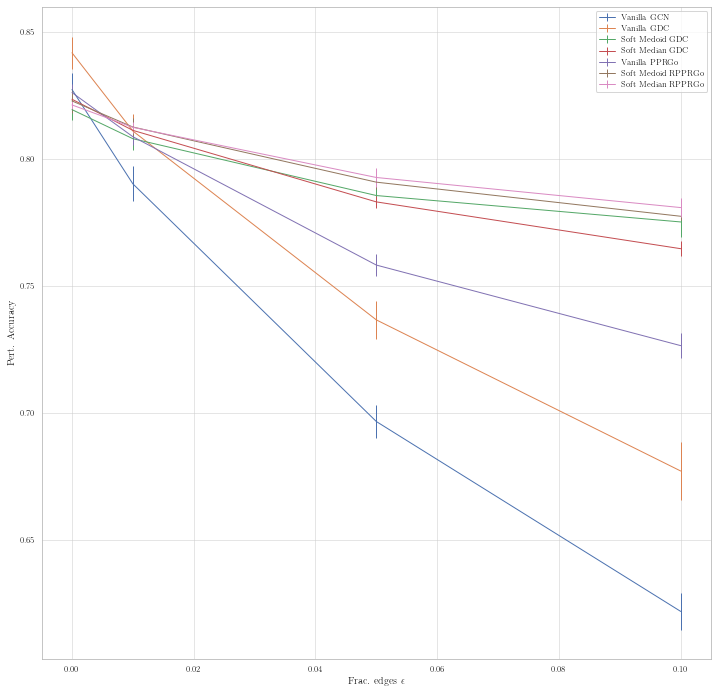

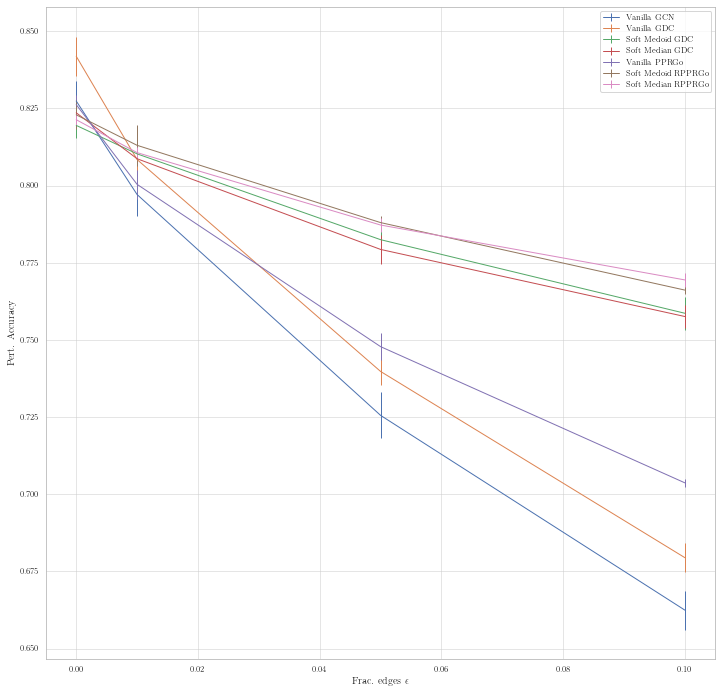

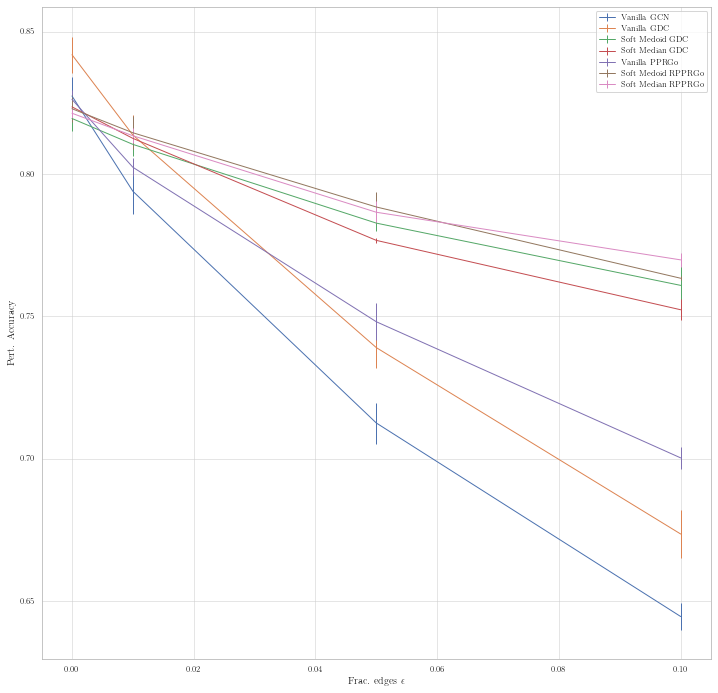

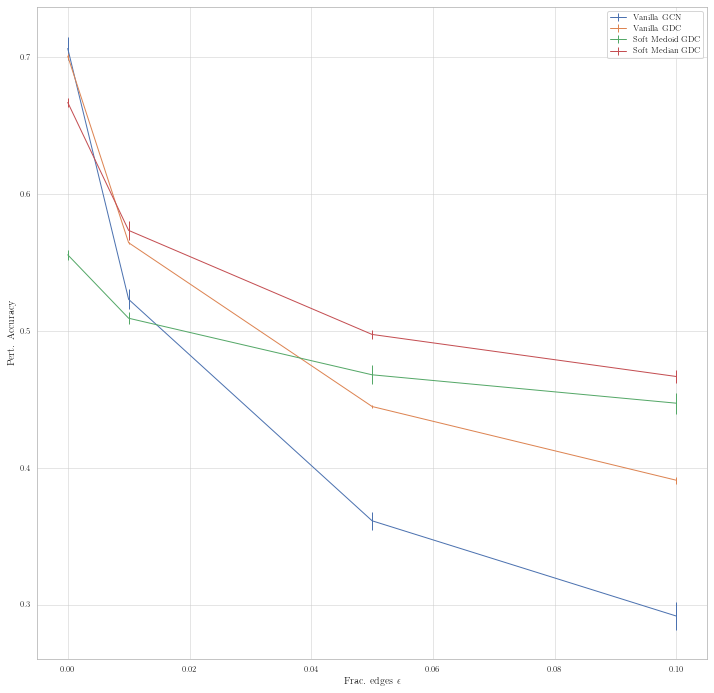

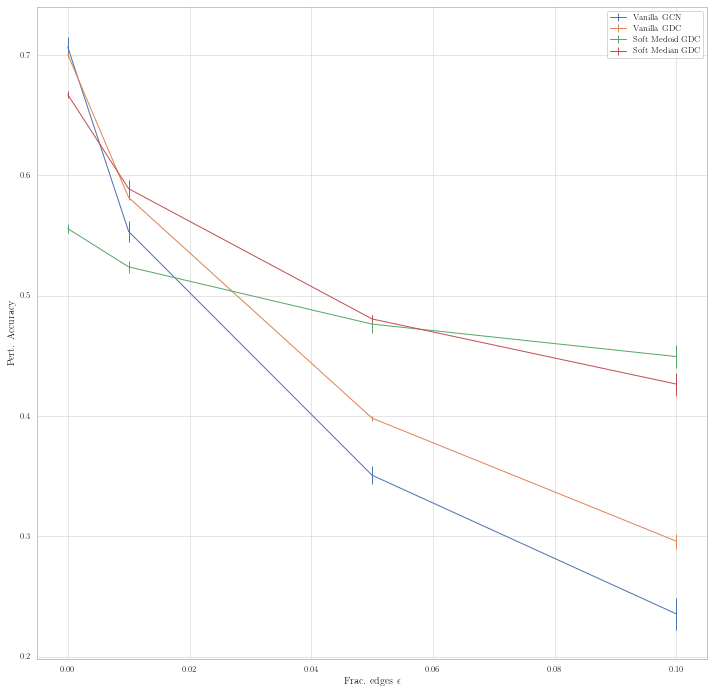

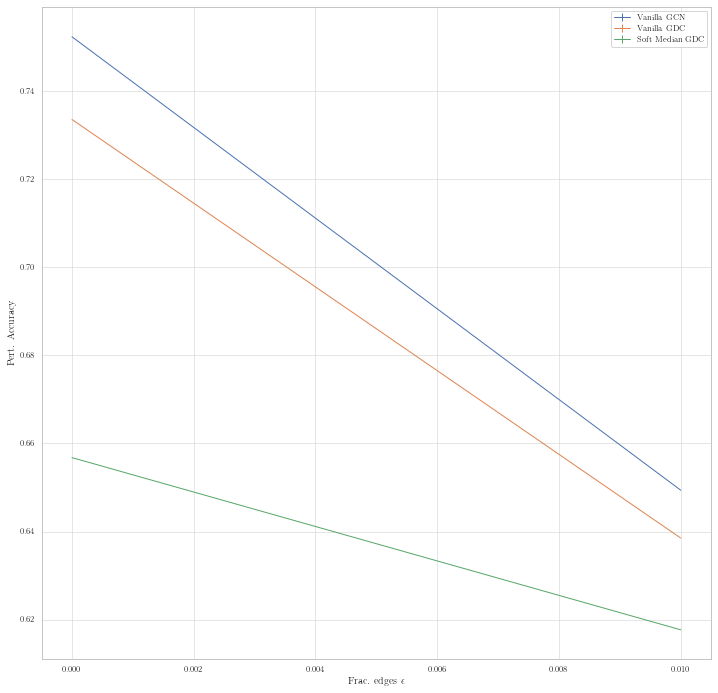

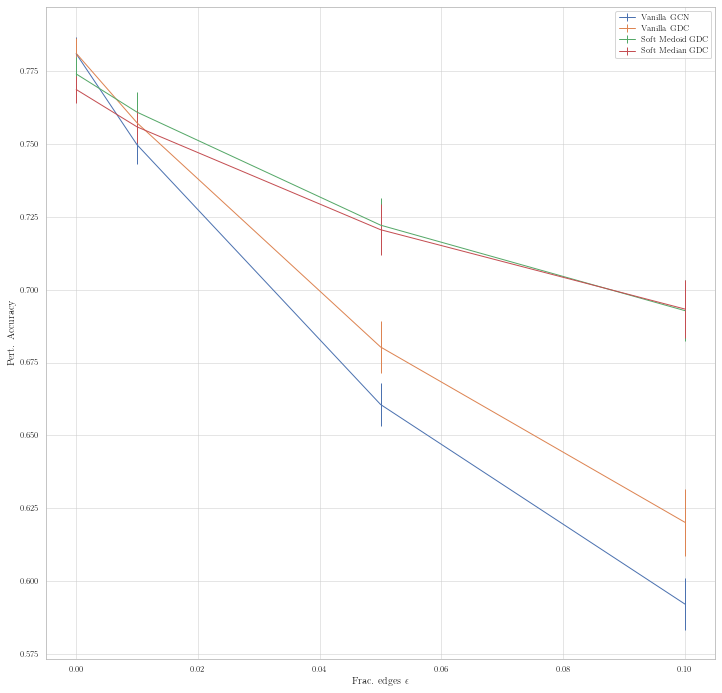

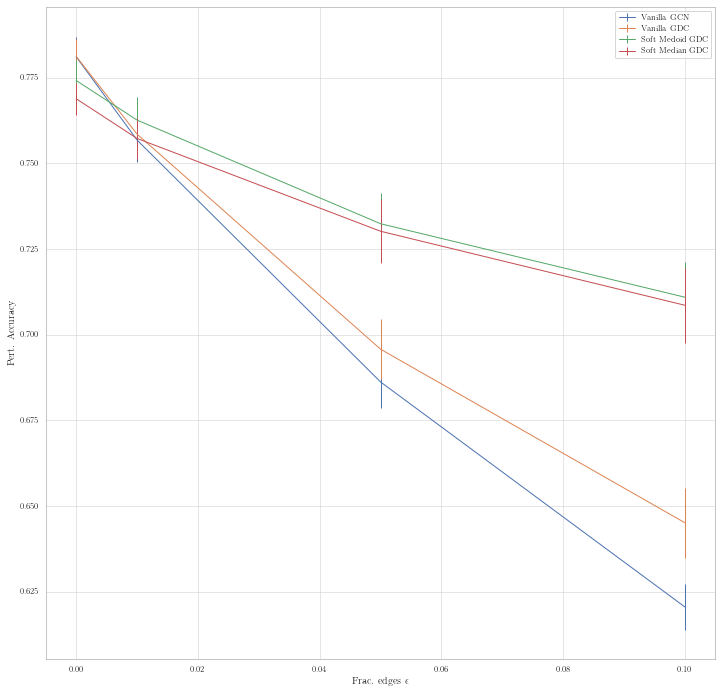

In [49]:
for (dataset, attack), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & ~((df_results['dataset'] == 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.2)'))
    & ~((df_results['dataset'] != 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.5)'))
    & ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
    & df_results['attack'].isin(attacks)
    & (df_results['epsilon'] <= 0.1)
    # Filter out the SVD outlier where it fails catastrophically
    & ((df_results.dataset != 'citeseer') | (df_results.label != 'SVD GCN') | (df_results.accuracy > 0.1))
].groupby(['dataset', 'attack']):       
    print(dataset, attack)
    
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

    for label in labels_non_batched + lables_batched:        
        if df_group[df_group.label == label].shape[0] == 0:
            continue
           
        df_values = df_group[df_group.label == label].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()
        
        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=label.replace(' (T=5.0)', '').replace(' (T=0.5)', '').replace(' (T=0.2)', '')
        )
    
    df_range = df_group.groupby('epsilon').accuracy.agg(['min', 'max']).reset_index()
    df_range['dataset'] = dataset
    df_range['attack'] = attack    
    
    plt.xlabel(epsilons_c)
    plt.ylabel('Pert. Accuracy')
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_no_legend', fig, close_fig=False)
    ax.legend()
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_legend',
        mod_label=lambda l: l,
        ncol=3
    )
    

## Split table for small datasets

In [193]:
small_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['cora_ml'], dataset_map['citeseer']]]
small_datasets

['\\rotatebox{90}{\\textbf{Cora ML}}', '\\rotatebox{90}{\\textbf{Citeseer}}']

In [194]:
small_datasets = small_datasets[:-1]
small_datasets

['\\rotatebox{90}{\\textbf{Cora ML}}']

In [195]:
drop_attacks = [attack_map['DICE']]
drop_attacks

['\\textbf{DICE}']

In [196]:
df_small = df_piv.loc[(slice(*small_datasets), slice(None))].drop(columns=drop_attacks)
df_small

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.032   
                                 Vanilla GDC                           0.03   
                                 SVD GCN (rank=50)       \underline{-0.001}   
                                 SVD GCN (rank=100)                   0.003   
                                 Jaccard GCN                          0.027   
                                 RGCN                                 0.025   
                                 Soft Medoid GDC                      0.011   
                                 Soft Median GDC                      0.013   
                                 Vanilla PPRGo                        0.019   
                                 Soft Medoid PPRGo           \textbf{0.011}   
                                 Soft Median PPRGo                    0.009   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                0.05   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.115   
                                 Vanilla GDC                        0.104   
                                 SVD GCN (rank=50)      \underline{0.011}   
                                 SVD GCN (rank=100)                 0.017   
                                 Jaccard GCN                        0.096   
                                 RGCN                        \textbf{0.1}   
                                 Soft Medoid GDC                    0.035   
                                 Soft Median GDC                    0.039   
                                 Vanilla PPRGo                      0.072   
                                 Soft Medoid PPRGo                  0.033   
                                 Soft Median PPRGo                  0.029   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.1   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.186   
                                 Vanilla GDC                \textbf{0.17}   
                                 SVD GCN (rank=50)      \underline{0.029}   
                                 SVD GCN (rank=100)                 0.036   
                                 Jaccard GCN               \textbf{0.156}   
                                 RGCN                      \textbf{0.165}   
                                 Soft Medoid GDC                    0.046   
                                 Soft Median GDC                    0.055   
                                 Vanilla PPRGo                      0.103   
                                 Soft Medoid PPRGo                  0.046   
                                 Soft Median PPRGo                  0.043   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   
                                 \textbf{Architecture}                          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   \textbf{0.037}   
                                 Vanilla GDC                            0.031   
                                 SVD GCN (rank=50)          \underline{0.002}   
                                 SVD GCN (rank=100)                     0.005   
                                 Jaccard GCN                   \textbf{0.029}   
                                 RGCN                                   0.025   
      

In [198]:
print(df_small\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        #float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global_small}
\begin{tabular}{llccccccccccccc}
\toprule
                                 & \textbf{Attack} & \multicolumn{3}{l}{\text

## Split table for large datasets

In [199]:
large_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['pubmed'], dataset_map['ogbn-arxiv'], dataset_map['ogbn-products']]]
large_datasets

['\\rotatebox{90}{\\textbf{PubMed}}',
 '\\rotatebox{90}{\\textbf{arXiv}}',
 '\\rotatebox{90}{\\textbf{Products}}']

In [200]:
drop_attacks = [attack_map['FGSM'], attack_map['PGD']]
drop_attacks

['\\textbf{greedy FGSM}', '\\textbf{PGD}']

In [201]:
df_large = df_piv.loc[(slice(large_datasets[0], large_datasets[-1]), slice(None))].drop(columns=drop_attacks)
df_large

TypeError: Level type mismatch: \rotatebox{90}{\textbf{Products}}

In [132]:
print(df_large\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        #float_format='%.2f',
        caption=r'\todo{Sth}', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llcccccccccc'
    )
)

NameError: name 'df_large' is not defined

# Compare losses

In [64]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\rotatebox{90}{\textbf{Attack}}'
epsilons_c = r'\makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)}'

epsilons = [0.01, 0.05, 0.1]
epsilon_marks = ['', r'\textit', r'\underline', r'\textbf']

In [65]:
loss_c = r'\textbf{Loss}'

loss_map = {
    'CE': 'CE',
    'CW': 'CW',
    'SCE': 'SCE',
    'MCE': 'MCE',
    'tanhMargin': 'tanh Margin',
    'Margin': 'Margin',
    'eluMargin': 'elu Margin',
    #'tanhMarginCW-0.25': '0.25 tanh Margin + 0.75 CW',
    #'tanhMarginCW-0.5': '0.5 tanh Margin + 0.5 CW',
    #'tanhMarginCW-0.625': '0.625 tanh Margin + 0.375 CW',
    #'tanhMarginCW-0.75': '0.75 tanh Margin + 0.25 CW',
    #'tanhMarginCW-0.9': '0.9 tanh Margin + 0.1 CW',
    #'tanhMarginCW-0.95': '0.95 tanh Margin + 0.05 CW',
    #'tanhMarginMCE-0.25': '0.25 tanh Margin + 0.75 MCE',
    'tanhMarginMCE-0.5': '0.5 tanh Margin + 0.5 MCE',
    #'tanhMarginMCE-0.625': '0.625 tanh Margin + 0.375 MCE',
    'tanhMarginMCE-0.75': '0.75 tanh Margin + 0.25 MCE',
    #'tanhMarginMCE-0.9': '0.9 tanh Margin + 0.1 MCE',
    #'tanhMarginMCE-0.95': '0.95 tanh Margin + 0.05 MCE',
}


def loss_str(loss: str) -> str:
    if isinstance(loss, str):
        return loss_map[loss]
    else:
        return loss_map['CE']
    
def transform_label(label: str):
    label = label.replace('\n', ' ').replace(' (T=0.5)','').replace(' (T=0.2)','').replace(' ', r'\\')
    return f'\makecell{{{label}}}'

In [66]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['seed'] = df_experiment['config.seed']
    df_result['batch_id'] = df_experiment['batch_id']
    df_result['loss'] = loss_str(df_experiment['config.attack_params.loss_type'])
    df_result['lr'] = df_experiment['config.attack_params.base_lr']

df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

,label,epsilon,accuracy,dataset,attack,seed,batch_id,loss,lr
0,Vanilla GCN,0.00,0.778640,pubmed,GreedyRBCD,0,13,MCE,NaN
361,Vanilla GDC,0.00,0.783487,pubmed,DICE,0,13,CE,NaN
360,Vanilla GCN,0.00,0.778640,pubmed,DICE,0,13,CE,NaN
352,Soft Medoid GDC (T=0.2),0.10,0.737052,pubmed,PRBCD,5,13,tanh Margin,NaN
351,Soft Medoid GDC (T=0.5),0.10,0.731081,pubmed,PRBCD,5,13,tanh Margin,NaN
...,...,...,...,...,...,...,...,...,...
9250,Vanilla GDC,0.01,0.638522,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9245,Vanilla GCN (surrogate),0.00,0.721687,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9244,Vanilla GCN,0.00,0.752346,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9246,Vanilla GDC,0.00,0.733569,ogbn-products,GreedyRBCD,0,21,MCE,NaN


In [67]:
df = []

for (dataset, attack, label, epsilon, loss), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon', 'loss']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon} collected runs for seed {df_group.seed.tolist()}')

    accuracy = calc_mean_and_error(df_group.accuracy, df_group.seed, with_error=False, decimal_places=4)
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy,
        loss_c: loss
    })
    
df = pd.DataFrame(df)

df = df[
    df[attack_c].isin([attack_map['PGD'], attack_map['FGSM']])
    & ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
]

df = df[df[epsilons_c].isin(epsilons)].copy()

df

,,\textbf{Architecture},\rotatebox{90}{\textbf{Attack}},\makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)},accuracy,\textbf{Loss}
8,\textbf{Citeseer},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7037,0.5 tanh Margin + 0.5 MCE
9,\textbf{Citeseer},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7164,CE
10,\textbf{Citeseer},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7109,CW
11,\textbf{Citeseer},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7070,MCE
12,\textbf{Citeseer},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7118,Margin
...,...,...,...,...,...,...
1403,\textbf{Cora ML},\makecell{Vanilla\\PPRGo},\textbf{PGD},0.10,0.7752,MCE
1404,\textbf{Cora ML},\makecell{Vanilla\\PPRGo},\textbf{PGD},0.10,0.7527,Margin
1405,\textbf{Cora ML},\makecell{Vanilla\\PPRGo},\textbf{PGD},0.10,0.7893,SCE
1406,\textbf{Cora ML},\makecell{Vanilla\\PPRGo},\textbf{PGD},0.10,0.7673,elu Margin


In [68]:
[
    loss_map[loss]
    for loss in loss_map.keys() if loss != loss_map['CE']
]

['CW',
 'SCE',
 'MCE',
 'tanh Margin',
 'Margin',
 'elu Margin',
 '0.5 tanh Margin + 0.5 MCE',
 '0.75 tanh Margin + 0.25 MCE']

In [69]:
df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    [transform_label(l) for l in labels_to_plot],
    inplace=True
)
df[dataset_c] = df[dataset_c].astype("category")
df[dataset_c].cat.set_categories(
    dataset_order,
    inplace=True
)
df[attack_c] = df[attack_c].astype("category")
df[attack_c].cat.set_categories(
    list(attack_map.values()),
    inplace=True
)
df[attack_c] = df[attack_c].cat.rename_categories([rf'\rotatebox{{90}}{{{cat}}}' for cat in df[attack_c].cat.categories])

df_piv = pd.pivot_table(
    df, 
    index=[attack_c, epsilons_c, loss_c], 
    columns=[dataset_c, architecture_c],
    values='accuracy',
    aggfunc=lambda x: ' '.join(x)
)

#df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

#for epsilon, mark in zip(epsilons, epsilon_marks):
#    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
#    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
#        partial(mark_best_and_second_best, first_mark=mark, second_mark='', axis=1, is_higher_better=False)
#    )

#def acc_to_mean_and_error(group: pd.DataFrame, with_error=True, decimal_places: int = 3):
#    return calc_mean_and_error(group['accuracy'], group['seed'], with_error=with_error, decimal_places=decimal_places)

#df_piv = df_piv.join(df_accuracy)
df_piv = df_piv.fillna('-')

ce_acc = df_piv.xs(loss_map['CE'], level=2, drop_level=False).values
nonce_acc = np.vstack([
    df_piv.xs(loss_map[loss], level=2, drop_level=False).values
    for loss in loss_map.keys() if loss != loss_map['CE']
])

row_idx = len(loss_map) * np.arange(df_piv.shape[0] // len(loss_map))
row_idx = (row_idx[:, None] 
           + df_piv.groupby(level=[0,1]).aggregate(lambda col: col.astype(float).argmin()).values
          ).flatten()

col_idx = np.tile(np.arange(df_piv.shape[1]), df_piv.shape[0] // len(loss_map))

mask = np.zeros(df_piv.shape).astype(bool)
mask[row_idx, col_idx] = True

df_piv = df_piv.mask(
    pd.DataFrame(mask, columns=df_piv.columns, index=df_piv.index),
    df_piv.applymap(lambda elem: rf'{epsilon_marks[-1]}{{{elem}}}')
)
df_piv

ValueError: operands could not be broadcast together with shapes (5,1) (6,22) 

In [ ]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy comparing the conventional losses with our loss. \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). We use random split with 20 nodes per class.', 
        label='tab:losscompare',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='lcl|cccccccccc|cccccccccc'
    )
)

## Plot selected

In [76]:
epsilons_c = r'Frac. edges $\epsilon$'

In [77]:
labels_selected = [
    'Vanilla GCN',
    #'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN',
    #'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=0.2)'
]

datasets_selected = ['citeseer', 'cora_ml']

In [78]:
df_results.loss.unique()

array(['MCE', 'CE', 'tanh Margin', 'SCE', 'Margin', 'elu Margin', 'CW',
       '0.75 tanh Margin + 0.25 MCE', '0.5 tanh Margin + 0.5 MCE'],
      dtype=object)

In [79]:
df_results


,label,epsilon,accuracy,dataset,attack,seed,batch_id,loss,lr
0,Vanilla GCN,0.00,0.778640,pubmed,GreedyRBCD,0,13,MCE,NaN
361,Vanilla GDC,0.00,0.783487,pubmed,DICE,0,13,CE,NaN
360,Vanilla GCN,0.00,0.778640,pubmed,DICE,0,13,CE,NaN
352,Soft Medoid GDC (T=0.2),0.10,0.737052,pubmed,PRBCD,5,13,tanh Margin,NaN
351,Soft Medoid GDC (T=0.5),0.10,0.731081,pubmed,PRBCD,5,13,tanh Margin,NaN
...,...,...,...,...,...,...,...,...,...
9250,Vanilla GDC,0.01,0.638522,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9245,Vanilla GCN (surrogate),0.00,0.721687,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9244,Vanilla GCN,0.00,0.752346,ogbn-products,GreedyRBCD,0,21,MCE,NaN
9246,Vanilla GDC,0.00,0.733569,ogbn-products,GreedyRBCD,0,21,MCE,NaN


citeseer FGSM Vanilla GCN -1.0
citeseer PGD Vanilla GCN 0.1
cora_ml FGSM Vanilla GCN -1.0


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases

cora_ml PGD Vanilla GCN 0.1


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


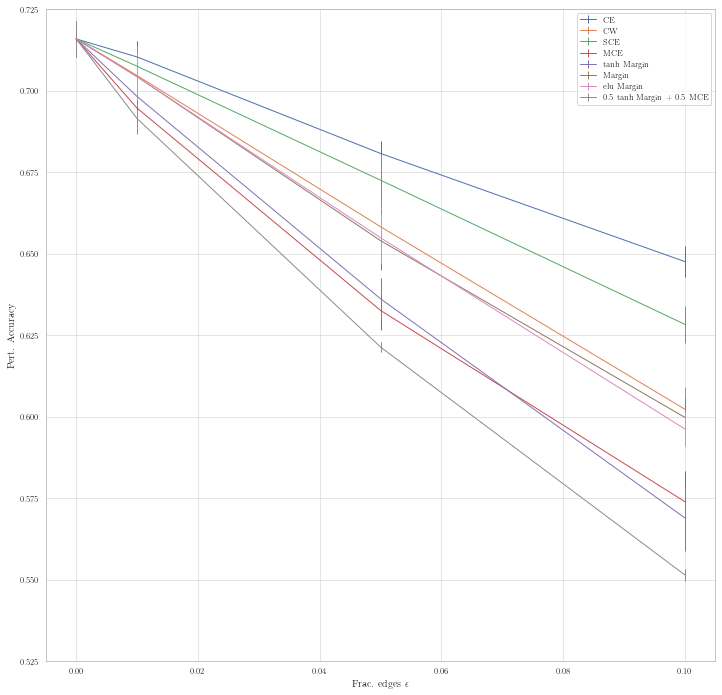

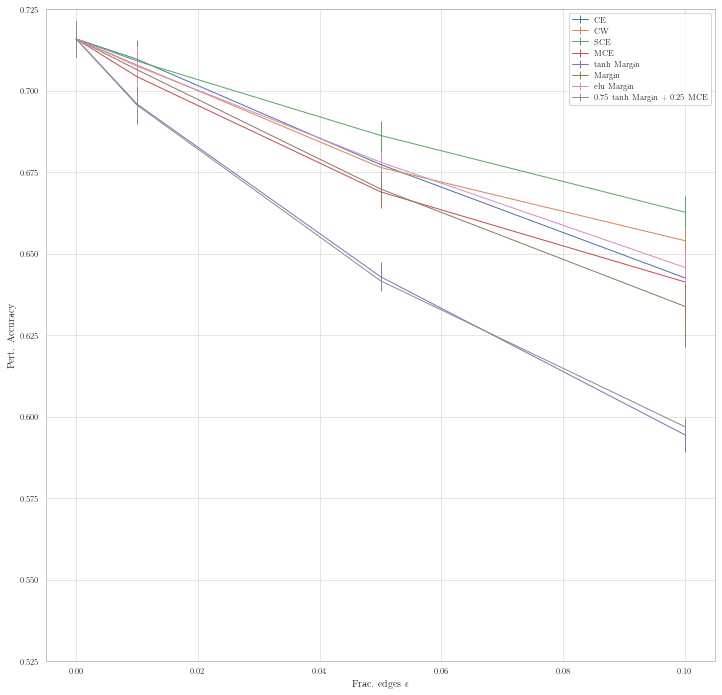

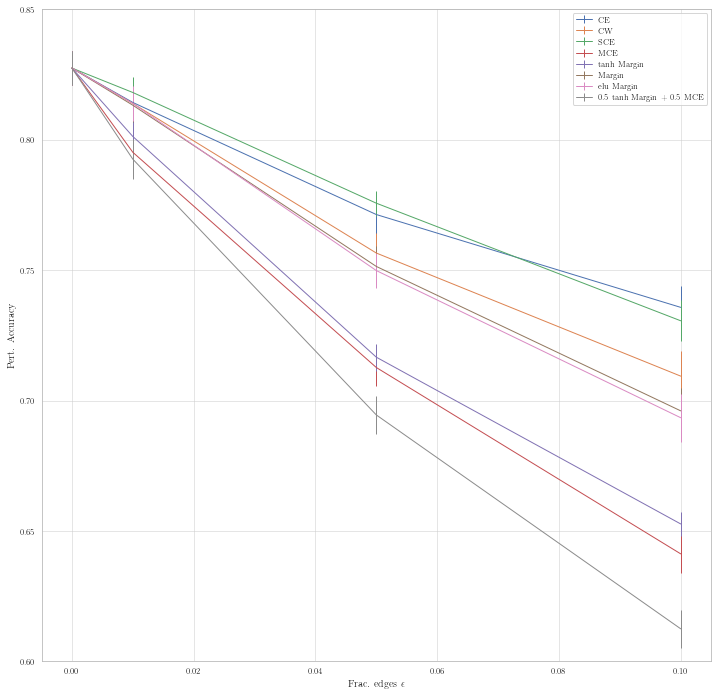

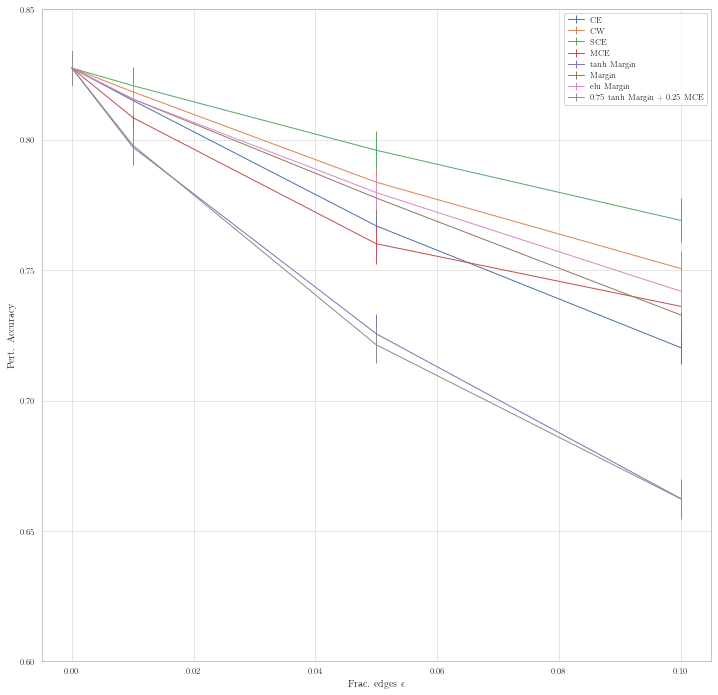

In [84]:
for (dataset, attack, label, lr), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_selected)
    & df_results['dataset'].isin(datasets_selected)
    & (df_results['epsilon'] <= 0.1)
].fillna(-1).groupby(['dataset', 'attack', 'label', 'lr']):       
    print(dataset, attack, label, lr)

    fig, ax = mpl_latex.newfig(width=0.25, ratio_yx=1)

    for loss in loss_map.values():

        if df_group[df_group.loss == loss].shape[0] == 0:
            continue

        df_values = df_group[df_group.loss == loss].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()

        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=loss
        )

    plt.xlabel(epsilons_c)
    if dataset == 'cora_ml':
        plt.ylim(0.6, 0.85)
    else:
        plt.ylim(0.525, 0.725)


    if label != 'Vanilla GCN':
        ax.get_yaxis().set_ticklabels([])

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_leglab', fig, close_fig=False)
    plt.ylabel('Pert. Accuracy')

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_legend', fig, close_fig=False)
    ax.legend()

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_legend',
        mod_label=lambda l: l,
        ncol=5
    )

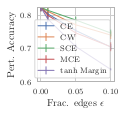

In [132]:
plt.gcf()

# Direct Attacks

In [195]:
df_experiments_direct = seml.get_results('neurips21_global_attack_direct',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])
df_experiments_direct.tail()

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.mem,slurm.sbatch_options.gres,config.overwrite,config.db_collection,config.dataset,config.data_dir,config.binary_attr,config.make_undirected,config.seed,config.attack,config.attack_params.loss_type,config.attack_params.search_space_size,config.epsilons,config.artifact_dir,config.model_storage_type,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_label,config.device,config.data_device,config.debug_level,result.results,config.attack_params.do_synchronize,config.attack_params.epochs,config.attack_params.fine_tune_epochs,config.attack_params.keep_heuristic
55,56,1,1,0-08:00,1,4,4G,gpu:1,56,neurips21_global_attack_direct,citeseer,datasets/,False,True,5,PRBCD,tanhMargin,100000,"[0, 0.01, 0.05, 0.1, 0.25]",cache,pretrained,evasion_global_adj,evasion_global_attr,Vanilla GCN,0,0,info,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",True,400.0,100.0,WeightOnly
56,57,1,1,0-08:00,1,4,4G,gpu:1,57,neurips21_global_attack_direct,citeseer,datasets/,False,True,5,PRBCD,tanhMargin,100000,"[0, 0.01, 0.05, 0.1, 0.25]",cache,pretrained,evasion_global_adj,evasion_global_attr,Vanilla GDC,0,0,info,"[{'label': 'Vanilla GDC', 'epsilon': 0, 'accur...",True,400.0,100.0,WeightOnly
57,58,1,1,0-08:00,1,4,4G,gpu:1,58,neurips21_global_attack_direct,citeseer,datasets/,False,True,5,PRBCD,tanhMargin,100000,"[0, 0.01, 0.05, 0.1, 0.25]",cache,pretrained,evasion_global_adj,evasion_global_attr,Soft Median GDC (T=1.0),0,0,info,"[{'label': 'Soft Median GDC (T=1.0)', 'epsilon...",True,400.0,100.0,WeightOnly
58,59,1,1,0-08:00,1,4,4G,gpu:1,59,neurips21_global_attack_direct,citeseer,datasets/,False,True,5,PRBCD,tanhMargin,100000,"[0, 0.01, 0.05, 0.1, 0.25]",cache,pretrained,evasion_global_adj,evasion_global_attr,Soft Median GDC (T=0.5),0,0,info,"[{'label': 'Soft Median GDC (T=0.5)', 'epsilon...",True,400.0,100.0,WeightOnly
59,60,1,1,0-08:00,1,4,4G,gpu:1,60,neurips21_global_attack_direct,citeseer,datasets/,False,True,5,PRBCD,tanhMargin,100000,"[0, 0.01, 0.05, 0.1, 0.25]",cache,pretrained,evasion_global_adj,evasion_global_attr,Soft Median GDC (T=0.2),0,0,info,"[{'label': 'Soft Median GDC (T=0.2)', 'epsilon...",True,400.0,100.0,WeightOnly


In [200]:
df_results_direct_list = [
    pd.DataFrame(r) 
    for r in df_experiments_direct['result.results']
]
for df_results_direct, (_, experiment) in zip(df_results_direct_list, df_experiments_direct.iterrows()):
    df_results_direct['dataset'] = experiment['config.dataset']
    df_results_direct['attack'] = experiment['config.attack']
    df_results_direct['seed'] = experiment['config.seed']
    df_results_direct['batch_id'] = experiment['batch_id']
    df_results_direct['novel_loss'] = (
        experiment['config.attack'] not in attack_loss_map
        or experiment['config.attack_params.loss_type'] == attack_loss_map[experiment['config.attack']]
    )
    
df_results_direct = pd.concat(df_results_direct_list, ignore_index=True)
df_results_direct = df_results_direct.sort_values('batch_id')
df_results_direct = df_results_direct.drop_duplicates([
    c for c in df_results_direct.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results_direct

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss
0,Vanilla GCN,0.00,0.815020,cora_ml,GreedyRBCD,0,1,True
203,Vanilla GCN,0.10,0.650593,cora_ml,PRBCD,5,1,True
202,Vanilla GCN,0.05,0.720158,cora_ml,PRBCD,5,1,True
201,Vanilla GCN,0.01,0.802767,cora_ml,PRBCD,5,1,True
200,Vanilla GCN,0.00,0.837549,cora_ml,PRBCD,5,1,True
...,...,...,...,...,...,...,...,...
97,Soft Median GDC (T=0.2),0.05,0.682888,citeseer,GreedyRBCD,0,1,True
96,Soft Median GDC (T=0.2),0.01,0.698931,citeseer,GreedyRBCD,0,1,True
95,Soft Median GDC (T=0.2),0.00,0.700000,citeseer,GreedyRBCD,0,1,True
93,Soft Median GDC (T=0.5),0.10,0.641711,citeseer,GreedyRBCD,0,1,True


In [203]:
df_direct = []

for (dataset, attack, label, epsilon), df_group in df_results_direct[
    df_results_direct['novel_loss']
    & df_results_direct['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon}-{label} collected runs for seed {df_group.seed.tolist()}')
    if label == 'Soft Median GDC (T=0.2)' and dataset == 'ogbn-products':
        continue
    if label == 'Soft Median GDC (T=5.0)' and dataset == 'ogbn-arxiv':
        continue

    values, seeds = df_group.accuracy.values, df_group.seed.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    accuracy = values[idx].mean()
    
    df_direct.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy
    })
    
df_direct = pd.DataFrame(df_direct)

df_direct[architecture_c] = df_direct[architecture_c].astype("category")
df_direct[architecture_c].cat.set_categories(
    list(dict.fromkeys([transform_label(l) for l in labels_to_plot]).keys()),
    inplace=True
)
df_direct[dataset_c] = df_direct[dataset_c].apply(lambda cat: rf'\rotatebox{{90}}{{{cat}}}').astype("category")
df_direct[dataset_c].cat.set_categories(
    [rf'\rotatebox{{90}}{{{cat}}}' for cat in dataset_order],
    inplace=True
)

#df = df.sort_values([dataset_c, architecture_c])

# df_direct = df_direct[df_direct[epsilons_c].isin(epsilons)].copy()


df_direct

,,\textbf{Architecture},\textbf{Attack},Frac. edges \(\boldsymbol{\epsilon}\),accuracy
0,\rotatebox{90}{\textbf{Citeseer}},Soft Median GDC (T=0.2),\textbf{GR-BCD (ours)},0.00,0.708200
1,\rotatebox{90}{\textbf{Citeseer}},Soft Median GDC (T=0.2),\textbf{GR-BCD (ours)},0.01,0.704813
2,\rotatebox{90}{\textbf{Citeseer}},Soft Median GDC (T=0.2),\textbf{GR-BCD (ours)},0.05,0.686631
3,\rotatebox{90}{\textbf{Citeseer}},Soft Median GDC (T=0.2),\textbf{GR-BCD (ours)},0.10,0.663993
4,\rotatebox{90}{\textbf{Citeseer}},Soft Median GDC (T=0.2),\textbf{GR-BCD (ours)},0.25,0.626381
5,\rotatebox{90}{\textbf{Citeseer}},Vanilla GCN,\textbf{GR-BCD (ours)},0.00,0.715865
6,\rotatebox{90}{\textbf{Citeseer}},Vanilla GCN,\textbf{GR-BCD (ours)},0.01,0.689127
7,\rotatebox{90}{\textbf{Citeseer}},Vanilla GCN,\textbf{GR-BCD (ours)},0.05,0.617825
8,\rotatebox{90}{\textbf{Citeseer}},Vanilla GCN,\textbf{GR-BCD (ours)},0.10,0.554189
9,\rotatebox{90}{\textbf{Citeseer}},Vanilla GCN,\textbf{GR-BCD (ours)},0.25,0.410160


In [206]:
df_piv_direct = pd.pivot_table(
    df_direct, 
    index=[dataset_c, architecture_c], 
    columns=[attack_c, epsilons_c], #['type', attack_c, ' '], 
    values='accuracy'#,
    #aggfunc=lambda x: ' '.join(x)
)

df_piv_direct = df_piv_direct[[c for attack in attack_order for c in df_piv_direct.columns if c[0] == attack]]

df_piv_direct = pd.merge(df_piv_direct, df_accuracy, on=['   ', architecture_c], how='left')

#df_piv_direct = df_piv_direct.apply(lambda row: row[-1] - row[:-1], axis=1).round(3)
df_piv_direct = df_piv_direct.round(3)

#print(df_piv_direct.to_markdown())

best_defenses = []
for i in np.array(df_piv_direct.index.get_level_values(0).unique()):
    df_slice = df_piv_direct.loc[(i, slice(None))]
    best_defenses.append([df_slice[col].astype(float).argmax() for col in df_slice])

df_piv_direct = df_piv_direct.applymap(lambda val: str(val) if val == val else val)
#for epsilon in epsilons:
#    current_columns = [c for c in df_piv_direct.columns if c[1] == epsilon]
#    df_piv_direct[current_columns] = df_piv_direct[current_columns].groupby(dataset_c).apply(
#        partial(mark_best_and_second_best, first_mark=best_attack_mark, second_mark='', axis=1, is_higher_better=False)
#    )

for i, bests in zip(np.array(df_piv_direct.index.get_level_values(0).unique()), best_defenses):
    df_slice = df_piv_direct.loc[(i, slice(None))]
    for col, best in zip(df_slice, bests):
        if best == -1:
            continue
        df_slice.loc[df_slice.index[best], col] = rf'{best_defense_mark}{{{df_slice.loc[df_slice.index[best], col]}}}'
    

#df_piv = pd.merge(df_piv, df_accuracy.round(2), on=['   ', architecture_c], how='left')
df_piv_direct = df_piv_direct.fillna('-')
df_piv_direct

\textbf{Attack}                                           \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                        0.0   
                                  \textbf{Architecture}                            
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                              0.827   
                                  Vanilla GDC                  \underline{0.842}   
                                  Soft Median GDC (T=0.2)                  0.824   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                  \underline{0.716}   
                                  Vanilla GDC                              0.707   
                                  Soft Median GDC (T=0.2)                  0.708   

\textbf{Attack}                                                               \
Frac. edges \(\boldsymbol{\epsilon}\)                                   0.01   
                                  \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                          0.789   
                                  Vanilla GDC              \underline{0.808}   
                                  Soft Median GDC (T=0.2)              0.807   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                          0.689   
                                  Vanilla GDC                          0.679   
                                  Soft Median GDC (T=0.2)  \underline{0.705}   

\textbf{Attack}                                                               \
Frac. edges \(\boldsymbol{\epsilon}\)                                   0.05   
                                  \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                          0.699   
                                  Vanilla GDC                          0.749   
                                  Soft Median GDC (T=0.2)  \underline{0.773}   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                          0.618   
                                  Vanilla GDC                          0.626   
                                  Soft Median GDC (T=0.2)  \underline{0.687}   

\textbf{Attack}                                                               \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.1   
                                  \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                          0.619   
                                  Vanilla GDC                          0.703   
                                  Soft Median GDC (T=0.2)  \underline{0.749}   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                          0.554   
                                  Vanilla GDC                          0.588   
                                  Soft Median GDC (T=0.2)  \underline{0.664}   

\textbf{Attack}                                                               \
Frac. edges \(\boldsymbol{\epsilon}\)                                   0.25   
                                  \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                          0.475   
                                  Vanilla GDC                          0.623   
                                  Soft Median GDC (T=0.2)  \underline{0.692}   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                           0.41   
                                  Vanilla GDC                          0.504   
                                  Soft Median GDC (T=0.2)  \underline{0.626}   

\textbf{Attack}                                           \textbf{PR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                        0.0   
                                  \textbf{Architecture}                            
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                              0.827   
                       

In [209]:
print(df_piv_direct.to_markdown())

|                                                                    | ('\\textbf{GR-BCD (ours)}', 0.0)   | ('\\textbf{GR-BCD (ours)}', 0.01)   | ('\\textbf{GR-BCD (ours)}', 0.05)   | ('\\textbf{GR-BCD (ours)}', 0.1)   | ('\\textbf{GR-BCD (ours)}', 0.25)   | ('\\textbf{PR-BCD (ours)}', 0.0)   | ('\\textbf{PR-BCD (ours)}', 0.01)   | ('\\textbf{PR-BCD (ours)}', 0.05)   | ('\\textbf{PR-BCD (ours)}', 0.1)   | ('\\textbf{PR-BCD (ours)}', 0.25)   | ('\\textbf{Acc.}', ' ')   |
|:-------------------------------------------------------------------|:-----------------------------------|:------------------------------------|:------------------------------------|:-----------------------------------|:------------------------------------|:-----------------------------------|:------------------------------------|:------------------------------------|:-----------------------------------|:------------------------------------|:--------------------------|
| ('\\rotatebox{90}{\\textbf{Cora ML}}', 'Vanilla 

# Datasets

In [44]:
def value_to_storage(val: float, decimals: int = 2):
    if val / 1e3 < 1:
        return f'{val:.{decimals}f} B'
    if val / 1e6 < 1:
        return f'{val / 1e3:.{decimals}f} kB'
    if val / 1e9 < 1:
        return f'{val / 1e6:.{decimals}f} MB'
    if val / 1e12 < 1:
        return f'{val / 1e9:.{decimals}f} GB'
    if val / 1e15 < 1:
        return f'{val / 1e12:.{decimals}f} TB'
    if val / 1e18 < 1:
        return f'{val / 1e15:.{decimals}f} PB'
    raise ValueError(f'{val} is too big for Peta!!!')

In [45]:
from ogb.nodeproppred import PygNodePropPredDataset

from rgnn_at_scale.data import load_dataset

dataset_df = []
for dataset in tqdm.tqdm(['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv', 'ogbn-products', 'ogbn-papers100M']):
    if dataset.startswith('ogbn'):
        pyg_dataset = PygNodePropPredDataset(root='/nfs/staff-ssd/geisler/dontrobme/datasets', name=dataset)
        nnodes = pyg_dataset[0].x.shape[0]
        nedges = pyg_dataset[0].edge_index.shape[1]
        nfeatures = pyg_dataset[0].x.shape[1]
    else:
        graph = load_dataset(dataset, '/nfs/staff-ssd/geisler/dontrobme/datasets').standardize(
            make_unweighted=True,
            make_undirected=True,
            no_self_loops=True,
            select_lcc=True
        )
        #graph = load_and_standardize(dataset)
        nnodes = graph.adj_matrix.shape[0]
        nedges = graph.adj_matrix.nnz
        nfeatures = graph.attr_matrix.shape[1]
    dataset_df.append({
            r'\textbf{Dataset}': dataset_map[dataset].replace(r'rotatebox{90}', r'textbf'),
            r'\textbf{\#Nodes $n$}': f'{nnodes:,}',
            r'\textbf{\#Edges $e$}': f'{nedges:,}',
            r'\textbf{\#Features $d$}': f'{nfeatures:,}',
            #r'\textbf{\#Possible edges}': f'{nnodes ** 2:.3E}',
            r'\textbf{Size (dense)}': value_to_storage(4 * nnodes ** 2),
            r'\textbf{Size (sparse)}': value_to_storage(2*8*nedges + 4*nedges),
        })
dataset_df = pd.DataFrame(dataset_df).set_index(r'\textbf{Dataset}')
dataset_df

 83%|████████▎ | 5/6 [00:37<00:07,  7.49s/it]


KeyboardInterrupt: 

In [ ]:
dataset_df.to_dict()

In [ ]:
print(dataset_df
    #.sort_index()
    .to_latex(
        float_format='%.2f',
        caption='Statistics of the used datasets. For the dense adjacency matrix we assume that each elements is represented by 4 bytes. In the sparse case we use two 8 byte integer pointers and a 4 bytes float value.', 
        label='tab:datasets',
        escape=False
    )
)

# PPR

In [ ]:
def ppr(A):
    A_norm = A / A.sum(-1)[:, None]
    return alpha * torch.inverse(torch.eye(4) + (alpha - 1) * A_norm)

def update(A_dense, ppr_original, u, v):
    i = torch.nonzero(u.flatten()).item()
    
    row = A_dense[i] + v
    row = row / row.sum()
    A_norm = A_dense[i] / A_dense[i].sum()
    row_diff = row - A_norm
    row_diff_norm = (alpha - 1) * row_diff
    print(row_diff_norm)

    P_inv = (1 / alpha) * ppr_original
    P_uv_inv = P_inv - (P_inv @ u @ row_diff_norm @ P_inv) / (1 + row_diff_norm @ P_inv @ u)
    ppr_update = alpha * P_uv_inv
    
    return ppr_update

alpha = 0.15
A_dense_list = [
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32)
]


u_list = [
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[1], [0], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [1], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)
]
v_list = [
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 12, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True)
]


for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)

In [ ]:
for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)